# Parameter Estimation Project:

### This project is based around a particle decay from which I will measure a parameter related to the matter/anti-matter asymmetry of the Universe

 The relevant decay X → D has the following probability distribution function (PDF) : $P( t ; \tau , \Delta m_s , V)   \propto   ( 1 + V sin(\Delta mt) )  e^{\frac{-t}{\tau}} $

t is the observable quantity - the decay time of each decay;

$\tau$ is a lifetime parameter : $\tau = 1.5$

$\Delta m$ is a mass difference parameter which leads to sinusoidal oscillations superimposed on
the exponential decay : $\Delta m = 20.0$

$V$ is a parameter which measures matter/anti-matter asymmetry and has the value zero if
the universe is symmetric (which we know it isnt): $V = 0.1$

***

### Part 1: Estimating statistical precision

The aim of part one is to determine the statistical precision one could measure each of the parameters using 100 Monte Carlo pseudo experiments each with 10000 decay events. To start, a class was made to define functions which calculate pdfs, their integrals, noramlising, negative log-likelihoods and data generation. For generating data, the box method was used. This involved creating data from a uniform random number generator (np.random.uniform), then only keeping those which fall under the normalised pdf. This could then be repeated unitl 10000 events were generated.

A scatter plot and histogram was then produced for 1 dataset in order to see if the functions were working correctly.

Next, a function was defined in order to initialise the class ready for the minimiser to vary parameters. This function could then be fed into another 'fit' function which minimises the parameters using minuit.

A for-loop was then set up to use the generate data function to produce 100 sets of distributions each with 10000 events. Another for-loop was then set up which performed the 'fit'/'minimiser' on each of the 100 datasets.

The mean, standard deviation, bias and standard error could then be evaluated for each of the parameters over the 100 datasets.

***

In [36]:
import numpy as np

from scipy.integrate import quad

import matplotlib.pyplot as plt

from iminuit import Minuit as im


In [2]:
# Defining parameter values

tmin = 0  # start of time range
tmax = 10  # end of time range
events = 10000  # number of events (decays)

tau = 1.5  # lifetime parameter of signal
delta_m = 20  # mass difference parameter
V=0.1  # matter/anti-matter parameter
tau_background = 8  # lifetime parameter of background distribution


In [3]:
class decay:

    #constructor
    def __init__(self, V, delta_m, tau, tmin, tmax):

        """
        Initialises the decay object with specified parameters.

        Parameters:
        - V: Scaling factor for the signal amplitude.
        - delta_m: Frequency parameter for the signal.
        - tau: Decay constant for the signal.
        - tmin: Minimum time value for integration.
        - tmax: Maximum time value for integration.
        """

        self.V = V
        self.delta_m = delta_m
        self.tau = tau
        self.tmin = tmin
        self.tmax = tmax


    def particle_pdf(self, t):

        """
        Calculates the decay pdf of the signal at given time points.

        Parameters:
        - t: Time values.

        Returns:
        - Particle pdf values.

        """

        return ((1 + self.V*np.sin(self.delta_m * t)) * np.exp(-t/self.tau))


    def integral(self):

        """
        Calculates the integral of the signal pdf using scipy.integrate.quad.

        Returns:
        - Signal integral value.

        """
        
        return quad(self.particle_pdf, self.tmin, self.tmax)[0]


    def evaluate(self, t_values):

        """
        Produces normalised pdf for given time values.

        Parameters:
        - t_values: Time values.

        Returns:
        - normalised pdf values.

        """


        return self.particle_pdf(t_values) / self.integral()

    
    
    def generate_data(self, events, tmin, tmax):

        """
        Generates random data points conditioned to lie underneath the normalised pdf.

        Parameters:
        - events: Number of data points to generate.
        - tmin: Minimum time value.
        - tmax: Maximum time value.

        Returns:
        - Randomly generated time values.

        """

        
        random_t = np.random.uniform(tmin, tmax, size=events) #generate random values for the x-axis (time)
        random_y = np.random.uniform(size=events) #generate random values for the y axis
    
        accept_y = self.evaluate(random_t) # only accept the y-values that are beneath the normalised pdf
        mask = random_y > accept_y  #apply a mask to get rid of the randomly produced y-values if they are larger than the pdf curve


        #loop to keep creating random values of y until all of the data points are beneath the pdf
        while any(mask):
        
            random_t[mask] = np.random.uniform(0, 10, size = np.count_nonzero(mask))
            random_y[mask] = np.random.uniform(size = np.count_nonzero(mask))
        
            accept_y[mask] = self.evaluate(random_t[mask])
            mask = random_y > accept_y
            
        return random_t

    
    def NLL(self, random_t):

        """
        Calculates the negative log likelihood for the normalised pdf.

        Parameters:
        - random_t: Randomly generated time values.

        Returns:
        - Negative log likelihood value.

        """

        return -np.sum(np.log(self.evaluate(random_t)))
        


#### Checking the PDF and data generation functions work for a single dataset:

In [4]:
pdf = decay(V, delta_m, tau, 0, 10)  #initialise decay class
tval = np.linspace(0,10,1000)

data = pdf.generate_data(10000, 0, 10)   # call the function to generate data

<function matplotlib.pyplot.show(close=None, block=None)>

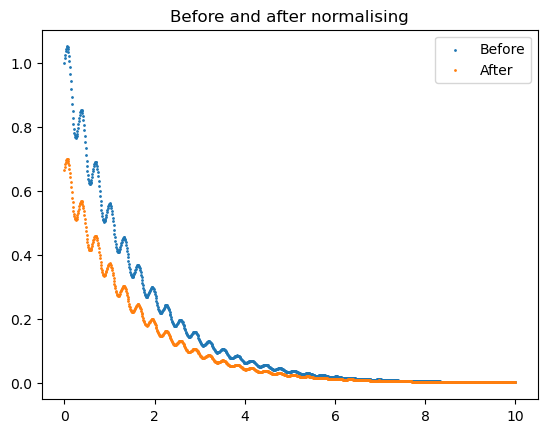

In [5]:
b4_y = pdf.particle_pdf(tval)
y = pdf.evaluate(tval)
plt.scatter(tval, b4_y, s=1, label = 'Before')
plt.scatter(tval, y, s=1, label = 'After')
plt.title("Before and after normalising")
plt.legend()
plt.show


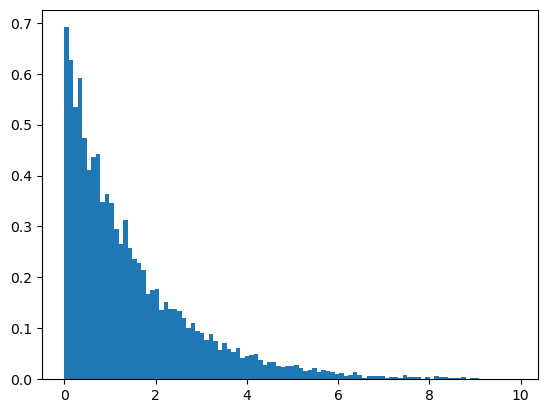

In [6]:
plt.hist(data, bins=100, density=True)
plt.show()

#### Performing Monte Carlo event generation:

In [7]:
#function initialise class in order to pass equation parameters to minuit
def nll_shell(V, delta_m, tau):    

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(t)

In [8]:
#function for the minimisation of the negative log likelihood
def fit(data):

    pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

    fit = im(nll_shell, V=V, delta_m = delta_m, tau = tau)
    fit.limits['V'] = [0, 1]
    fit.limits['delta_m'] = [0, 100]
    fit.limits['tau'] = [0, 10]
    fit.errordef = 0.5
    fit.migrad()

    return fit

In [9]:
#creating an instance of the decay class with the starting values for the parameters
decay_instance = decay(V=0.1, delta_m=20, tau=1.5, tmin=0, tmax=10)

#number of sets to generate
num_sets = 100

#empty list to store the generated data sets
data_sets = []

#loop to generate multiple sets of data
for i in range(num_sets):
    time = decay_instance.generate_data(events=10000, tmin=0, tmax=10)
    data_sets.append(time)

In [10]:
#creating an empty array for the results of the minimisation of parameters
looped_data = np.zeros((100, 3))

#loop to perform minimisation on each of the *100* datasets
for i in range(100):
    t = data_sets[i]
    looped_data[i] = fit(t).values

In [11]:
#calculating the mean, standard deviation and standard error on the parameter estimations

parameters = np.mean(looped_data, axis=0)
error_std = np.std(looped_data, axis=0)

In [12]:
print(f'Parameters Mean Value | V : {parameters[0]}, dm: {parameters[1]}, tau: {parameters[2]}')
print(f'Parameters Bias Value | V : {0.1 - parameters[0]}, dm: {20 - parameters[1]}, tau: {1.5 - parameters[2]}')
print(f'Standard Deviation | V : {error_std[0]}, dm: {error_std[1]}, tau: {error_std[2]}')
print(f'Error on the mean | V : {error_std[0]/np.sqrt(100)}, dm: {error_std[1]/np.sqrt(100)}, tau: {error_std[2]/np.sqrt(100)}')

Parameters Mean Value | V : 0.10063106480422444, dm: 20.00964869298605, tau: 1.5001965623952989
Parameters Bias Value | V : -0.0006310648042244377, dm: -0.009648692986051088, tau: -0.00019656239529886044
Standard Deviation | V : 0.013219568255851622, dm: 0.07850075848766491, tau: 0.01451385179258021
Error on the mean | V : 0.0013219568255851623, dm: 0.007850075848766491, tau: 0.0014513851792580209


##### The statistical precision of each parameter is given by the standard error on the mean:

 Parameter | Mean value | Standard deviation | Bias | Standard error on mean (precision of bias)
:---------:|:----------:|:------------------:|:-----:|:----------------------:
V         | 0.101      | 0.013              | -0.0006| 0.0013
$\Delta m$| 20.010    | 0.079              | -0.0096 | 0.0079
$\tau$    | 1.500      | 0.015              | 0.0002 | 0.0015


The bias on each parameter is at least an order of magnitude smaller than the standard deviation of the mean value. This deams them insignigicant.

### Part 2: Estimating possible bias due to an unaccounted for background:

The aim of part two is to determine if there is a possible bias on the data/paramaters due to an unaccounted for background. This was going to be done changing the underlying background distribution several times and measuring how the fitted parameters change.
To start, a copy of the first class was made, but with modifications for a background pdf, a background integral and then a combined function which sums the normalisation of them both while multiplying by there respective background or signal fractions. Again the box method for data generation was used.

An instance of this second class was made for each background fractions in order to produced data for each type.
This was then plotted as histograms in order to visualise how the background distribution changed the overall pdf.
Just as before, a function was defined for each background fraction in order to initialise the class ready for the minimiser to vary parameters. This function was then fed into minuit to perform minimisation of the nll. 

Unlike part 1, here we are only generating one data-set of events for each background fraction.

A plot of how the parameters vary with background fraction was then made in order to visualise whether there were any bias' / trends.



***

##### Creating a new class which has functions to include the background distribution as well as the signal:

In [13]:
class decay2:

    #constructor
    def __init__(self, V, delta_m, tau, tmin, tmax, tau_background, F):

        """
        Initializes the decay2 object with specified parameters.

        Parameters:
        - V: Scaling factor for the signal amplitude.
        - delta_m: Frequency parameter for the signal.
        - tau: Decay constant for the signal.
        - tmin: Minimum time value for integration.
        - tmax: Maximum time value for integration.
        - tau_background: Decay constant for the background.
        - F: Fraction of background events.

        """

        self.V = V
        self.delta_m = delta_m
        self.tau = tau
        self.tmin = tmin
        self.tmax = tmax
        self.tau_background = tau_background
        self.F = F


    
    def particle_pdf(self, t):

        """
        Calculates the decay pdf of the signal at given time points.

        Parameters:
        - t: Time values.

        Returns:
        - Particle pdf values.

        """

        return ((1 + self.V*np.sin(self.delta_m * t)) * np.exp(-t/self.tau))

    
    def background_pdf(self, t):

        """
        Calculates the decay pdf of the background at given time points.

        Parameters:
        - t: Time values.

        Returns:
        - Background pdf values.

        """

        return np.exp(-t/self.tau_background)


    def combined(self, t):

        """
        Combines the normalised signal and background pdfs.

        Parameters:
        - t: Time values.

        Returns:
        - Combined pdf values.

        """
        
        return (1-self.F)*self.particle_pdf(t)/self.signal_integral() + self.F*self.background_pdf(t)/self.background_integral()


     
    def signal_integral(self):

        """
        Calculates the integral of the signal pdf using scipy.integrate.quad.

        Returns:
        - Signal integral value.

        """
        
        return quad(self.particle_pdf, self.tmin, self.tmax)[0]

    
    def background_integral(self):

        """
        Calculates the integral of the background pdf using scipy.integrate.quad.

        Returns:
        - Background integral value.

        """
        
        return quad(self.background_pdf, self.tmin, self.tmax)[0]


    
    def evaluate(self, t_values):
        
        """
        Produces the combined normalised pdf for given time values.

        Parameters:
        - t_values: Time values.

        Returns:
        - Combined normalised pdf values.

        """

        return ((self.particle_pdf(t_values) / self.signal_integral()) + (self.background_pdf(t_values) / self.background_integral()))

    
    
    
    #note the change here in using the combined function instead of evaluate(like in the first decay class) as it includes background fraction
    def generate_data(self, events, tmin, tmax):

        """
        Generates random data points conditioned to lie underneath the normalized pdf.

        Parameters:
        - events: Number of data points to generate.
        - tmin: Minimum time value.
        - tmax: Maximum time value.

        Returns:
        - Randomly generated time values.

        """

        random_t = np.random.uniform(tmin, tmax, size=events) #generate random values for the x-axis (time)
        random_y = np.random.uniform(size=events) #generate random values for the y axis
    
        accept_y = self.combined(random_t) # only accept the y-values that are beneath the normalised pdf
        mask = random_y > accept_y  #apply a mask to get rid of the randomly produced y-values if they are larger than the pdf curve


        #loop to keep creating random values of y until all of the data points are beneath the pdf
        while any(mask):
        
            random_t[mask] = np.random.uniform(0, 10, size = np.count_nonzero(mask))
            random_y[mask] = np.random.uniform(size = np.count_nonzero(mask))
        
            accept_y[mask] = self.combined(random_t[mask])
            mask = random_y > accept_y
            
        return random_t

    
    
    #note the change here in using the combined function instead of evaluate(like in the first decay class) as it includes background fraction
    def NLL(self, random_t):

        """
        Calculates the negative log likelihood for the normalised pdf.

        Parameters:
        - random_t: Randomly generated time values.

        Returns:
        - Negative log likelihood value.

        """

        return -np.sum(np.log(self.combined(random_t)))
        


##### Making sure the function that combines the signal and background works properly:

In [14]:
#initialise decay classes for each background fraction value
F0_pdf2 = decay2(V, delta_m, tau, 0, 10, tau_background, 0)  
F01_pdf2 = decay2(V, delta_m, tau, 0, 10, tau_background, 0.1)
F02_pdf2 = decay2(V, delta_m, tau, 0, 10, tau_background, 0.2)
F03_pdf2 = decay2(V, delta_m, tau, 0, 10, tau_background, 0.3)
F04_pdf2 = decay2(V, delta_m, tau, 0, 10, tau_background, 0.4)

In [15]:
# call the functions to generate data for each signal fraction

F0_data = F0_pdf2.generate_data(10000, 0, 10)  
F1_data = F01_pdf2.generate_data(10000, 0, 10)
F2_data = F02_pdf2.generate_data(10000, 0, 10)
F3_data = F03_pdf2.generate_data(10000, 0, 10)
F4_data = F04_pdf2.generate_data(10000, 0, 10)

y0 = F0_pdf2.combined(F0_data)
y1 = F01_pdf2.combined(F1_data)
y2 = F02_pdf2.combined(F2_data)
y3 = F03_pdf2.combined(F3_data)
y4 = F04_pdf2.combined(F4_data)

<function matplotlib.pyplot.show(close=None, block=None)>

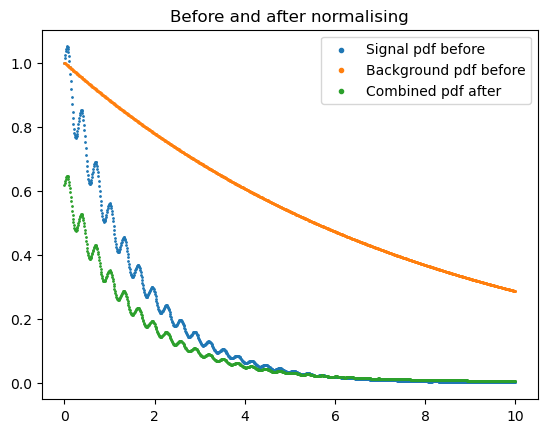

In [16]:
tval = np.linspace(0,10,1000)

b4_y = F01_pdf2.particle_pdf(tval)
bb4_y = F01_pdf2.background_pdf(tval)
y = F01_pdf2.combined(tval)
plt.scatter(tval, b4_y, s=1, label = 'Signal pdf before')
plt.scatter(tval, bb4_y, s=1, label = 'Background pdf before')
plt.scatter(tval, y, s=1, label = 'Combined pdf after')
plt.title("Before and after normalising")
plt.legend(markerscale=3)
plt.show


This plot gives a good indication of how the background distribution and its fraction changes the combined pdf

##### Plotting how the background fraction changes the pdf:

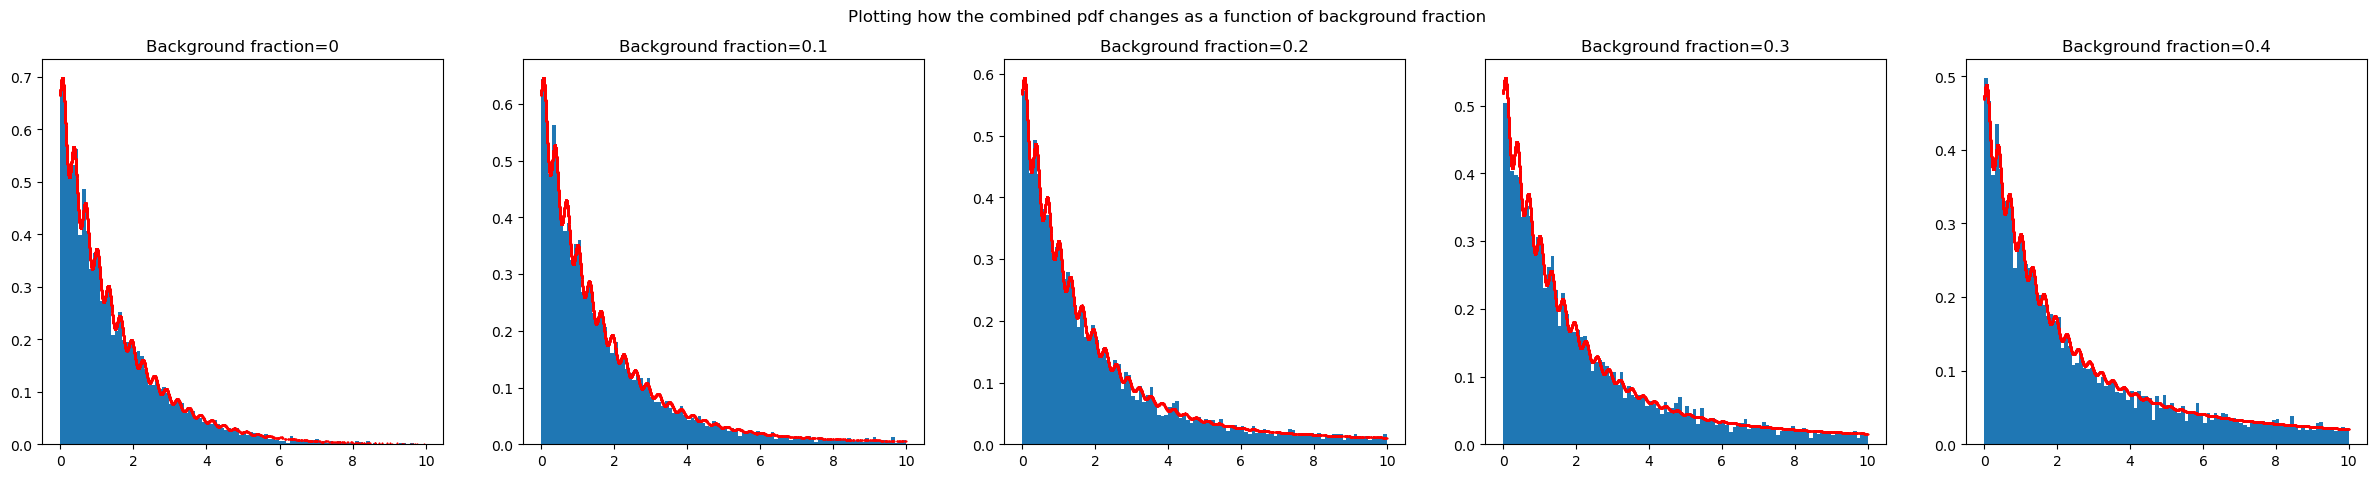

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30,5))

fig.suptitle('Plotting how the combined pdf changes as a function of background fraction')

ax1.set_title("Background fraction=0")
ax1.hist(F0_data, bins = 100, density=True)
ax1.scatter(F0_data, y0, s=1, color='red', linewidth=0.5)


ax2.set_title("Background fraction=0.1")
ax2.hist(F1_data, bins = 100, density=True)
ax2.scatter(F1_data, y1, s=1, color='red', linewidth=0.5)

ax3.set_title("Background fraction=0.2")
ax3.hist(F2_data, bins = 100, density=True)
ax3.scatter(F2_data, y2, s=1, color='red', linewidth=0.5)

ax4.set_title("Background fraction=0.3")
ax4.hist(F3_data, bins = 100, density=True)
ax4.scatter(F3_data, y3, s=1, color='red', linewidth=0.5)

ax5.set_title("Background fraction=0.4")
ax5.hist(F4_data, bins = 100, density=True)
ax5.scatter(F4_data, y4, s=1, color='red', linewidth=0.5)

plt.show()

It can be seen that as the background fraction increases, the combined pdf has a longer exponential tail - a result of the background
exponential having a longer lifetime. The oscillation amplitudes also aren't as pronounced, as the background does not contain oscillations.

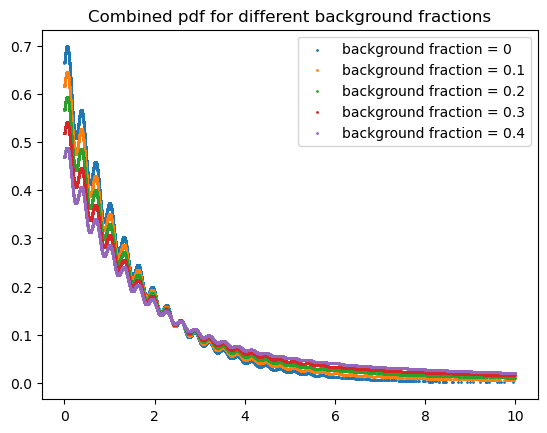

In [18]:
plt.scatter(F0_data, y0, s=1, label = 'background fraction = 0')
plt.scatter(F1_data, y1, s=1, label = 'background fraction = 0.1')
plt.scatter(F2_data, y2, s=1, label = 'background fraction = 0.2')
plt.scatter(F3_data, y3, s=1, label = 'background fraction = 0.3')
plt.scatter(F4_data, y4, s=1, label = 'background fraction = 0.4')
plt.title("Combined pdf for different background fractions")
plt.legend()

##### Fitting our **signal only** pdf to the data containing background and finding best fit parameters:

In [19]:
#function initialise class in order to pass equation parameters to minuit
def nll_shell0(V, delta_m, tau): 

    """
    Initializes the decay class for a background fraction of 0.

    Parameters:
    - V: Scaling factor for the signal amplitude.
    - delta_m: Frequency parameter for the signal.
    - tau: Decay constant for the signal.

    Returns:
    - Negative log likelihood value.

    """

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(F0_data)

In [20]:
# running minuit for background fraction of 0

pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

fit0 = im(nll_shell0, V=V, delta_m = delta_m, tau = tau)
fit0.limits['V'] = [0, 1]
fit0.limits['delta_m'] = [0, 100]
fit0.limits['tau'] = [0, 10]
fit0.errordef = 0.5
fit0.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.386e+04                  │              Nfcn = 47               │
│ EDM = 1.21e-05 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V       │   0.108   │   0.014   │            │            │    0    │    1    │       │
│ 1 │ delta_m │   20.05   │   0.12    │            │            │    0    │   100   │       │
│ 2 │ tau     │   1.495   │   0.015   │            │            │    0    │   10    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        V  delta_m      tau │
├─────────┼────────────────────────────┤
│       V │ 0.000201  0.02e-3  0.01e-3 │
│ delta_m │  0.02e-3   0.0143       -0 │
│     tau │  0.01e-3       -0 0.000237 │
└─────────┴────────────────────────────┘

In [21]:
# parameter values and errors

V_est0, del_m_est0, tau_est0 = fit0.values[0:]
V_err0, del_m_err0, tau_err0 = fit0.errors[0:]

In [22]:
def nll_shell1(V, delta_m, tau):    

    """
    Initializes the decay class for a background fraction of 0.1

    Parameters:
    - V: Scaling factor for the signal amplitude.
    - delta_m: Frequency parameter for the signal.
    - tau: Decay constant for the signal.

    Returns:
    - Negative log likelihood value.

    """

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(F1_data)

In [23]:
# running minuit for background fraction of 0.1

pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

fit1 = im(nll_shell1, V=V, delta_m = delta_m, tau = tau)
fit1.limits['V'] = [0, 1]
fit1.limits['delta_m'] = [0, 100]
fit1.limits['tau'] = [0, 10]
fit1.errordef = 0.5
fit1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.525e+04                  │              Nfcn = 56               │
│ EDM = 3.26e-06 (Goal: 0.0001)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V       │   0.089   │   0.014   │            │            │    0    │    1    │       │
│ 1 │ delta_m │   20.02   │   0.12    │            │            │    0    │   100   │       │
│ 2 │ tau     │   1.735   │   0.018   │            │            │    0    │   10    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        V  delta_m      tau │
├─────────┼────────────────────────────┤
│       V │   0.0002  0.02e-3  0.01e-3 │
│ delta_m │  0.02e-3   0.0135        0 │
│     tau │  0.01e-3        0 0.000337 │
└─────────┴────────────────────────────┘

In [24]:
# parameter values and errors

V_est1, del_m_est1, tau_est1 = fit1.values[0:]
V_err1, del_m_err1, tau_err1 = fit1.errors[0:]

In [25]:
def nll_shell2(V, delta_m, tau):  

    """
    Initializes the decay class for a background fraction of 0.2

    Parameters:
    - V: Scaling factor for the signal amplitude.
    - delta_m: Frequency parameter for the signal.
    - tau: Decay constant for the signal.

    Returns:
    - Negative log likelihood value.

    """

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(F2_data)

In [26]:
# running minuit for background fraction of 0.2

pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

fit2 = im(nll_shell2, V=V, delta_m = delta_m, tau = tau)
fit2.limits['V'] = [0, 1]
fit2.limits['delta_m'] = [0, 100]
fit2.limits['tau'] = [0, 10]
fit2.errordef = 0.5
fit2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.674e+04                  │              Nfcn = 76               │
│ EDM = 6.22e-07 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V       │   0.112   │   0.014   │            │            │    0    │    1    │       │
│ 1 │ delta_m │   19.92   │   0.04    │            │            │    0    │   100   │       │
│ 2 │ tau     │   2.067   │   0.023   │            │            │    0    │   10    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        V  delta_m      tau │
├─────────┼────────────────────────────┤
│       V │   0.0002 -0.01e-3  0.01e-3 │
│ delta_m │ -0.01e-3    0.002        0 │
│     tau │  0.01e-3        0 0.000527 │
└─────────┴────────────────────────────┘

In [27]:
# parameter values and errors


V_est2, del_m_est2, tau_est2 = fit2.values[0:]
V_err2, del_m_err2, tau_err2 = fit2.errors[0:]

In [28]:
def nll_shell3(V, delta_m, tau):

    """
    Initializes the decay class for a background fraction of 0.3

    Parameters:
    - V: Scaling factor for the signal amplitude.
    - delta_m: Frequency parameter for the signal.
    - tau: Decay constant for the signal.

    Returns:
    - Negative log likelihood value.

    """

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(F3_data)

In [29]:
# running minuit for background fraction of 0.3

pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

fit3 = im(nll_shell3, V=V, delta_m = delta_m, tau = tau)
fit3.limits['V'] = [0, 1]
fit3.limits['delta_m'] = [0, 100]
fit3.limits['tau'] = [0, 10]
fit3.errordef = 0.5
fit3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.788e+04                  │              Nfcn = 92               │
│ EDM = 9.02e-07 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V       │   0.091   │   0.014   │            │            │    0    │    1    │       │
│ 1 │ delta_m │   19.91   │   0.07    │            │            │    0    │   100   │       │
│ 2 │ tau     │   2.392   │   0.028   │            │            │    0    │   10    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        V  delta_m      tau │
├─────────┼────────────────────────────┤
│       V │ 0.000201 -0.02e-3  0.01e-3 │
│ delta_m │ -0.02e-3  0.00558        0 │
│     tau │  0.01e-3        0 0.000791 │
└─────────┴────────────────────────────┘

In [30]:
# parameter values and errors

V_est3, del_m_est3, tau_est3 = fit3.values[0:]
V_err3, del_m_err3, tau_err3 = fit3.errors[0:]

In [31]:
def nll_shell4(V, delta_m, tau): 

    """
    Initializes the decay class for a background fraction of 0.4

    Parameters:
    - V: Scaling factor for the signal amplitude.
    - delta_m: Frequency parameter for the signal.
    - tau: Decay constant for the signal.

    Returns:
    - Negative log likelihood value.

    """

    pdf = decay(V, delta_m, tau, 0, 10)
    
    return pdf.NLL(F4_data)

In [32]:
# running minuit for background fraction of 0.4

pdf = decay(V, delta_m, tau, tmin, tmax)  # initialise class

fit4 = im(nll_shell4, V=V, delta_m = delta_m, tau = tau)
fit4.limits['V'] = [0, 1]
fit4.limits['delta_m'] = [0, 100]
fit4.limits['tau'] = [0, 10]
fit4.errordef = 0.5
fit4.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.88e+04                   │              Nfcn = 88               │
│ EDM = 3.02e-06 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V       │   0.063   │   0.014   │            │            │    0    │    1    │       │
│ 1 │ delta_m │   19.98   │   0.12    │            │            │    0    │   100   │       │
│ 2 │ tau     │   2.730   │   0.034   │            │            │    0    │   10    │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │        V  delta_m      tau │
├─────────┼────────────────────────────┤
│       V │ 0.000202        0  0.02e-3 │
│ delta_m │        0   0.0134   0.0000 │
│     tau │  0.02e-3   0.0000  0.00117 │
└─────────┴────────────────────────────┘

In [33]:
# parameter values and errors

V_est4, del_m_est4, tau_est4 = fit4.values[0:]
V_err4, del_m_err4, tau_err4 = fit4.errors[0:]

In [34]:
x = [0, 0.1, 0.2, 0.3, 0.4] # background fraction (x-axis)

yv = [V_est0, V_est1, V_est2, V_est3, V_est4] #V parameter values (y-axis)
yverr = [V_err0, V_err1, V_err2, V_err3, V_err4] #V parameter errors

ym = [del_m_est0, del_m_est1, del_m_est2, del_m_est3, del_m_est4] # delta m parameter values (y-axis)
ymerr = [del_m_err0, del_m_err1, del_m_err2, del_m_err3, del_m_err4] # delta m errors

yt = [tau_est0, tau_est1, tau_est2, tau_est3, tau_est4] #tau parameter values (y-axis)
yterr = [tau_err0, tau_err1, tau_err2, tau_err3, tau_err4] # tau errors

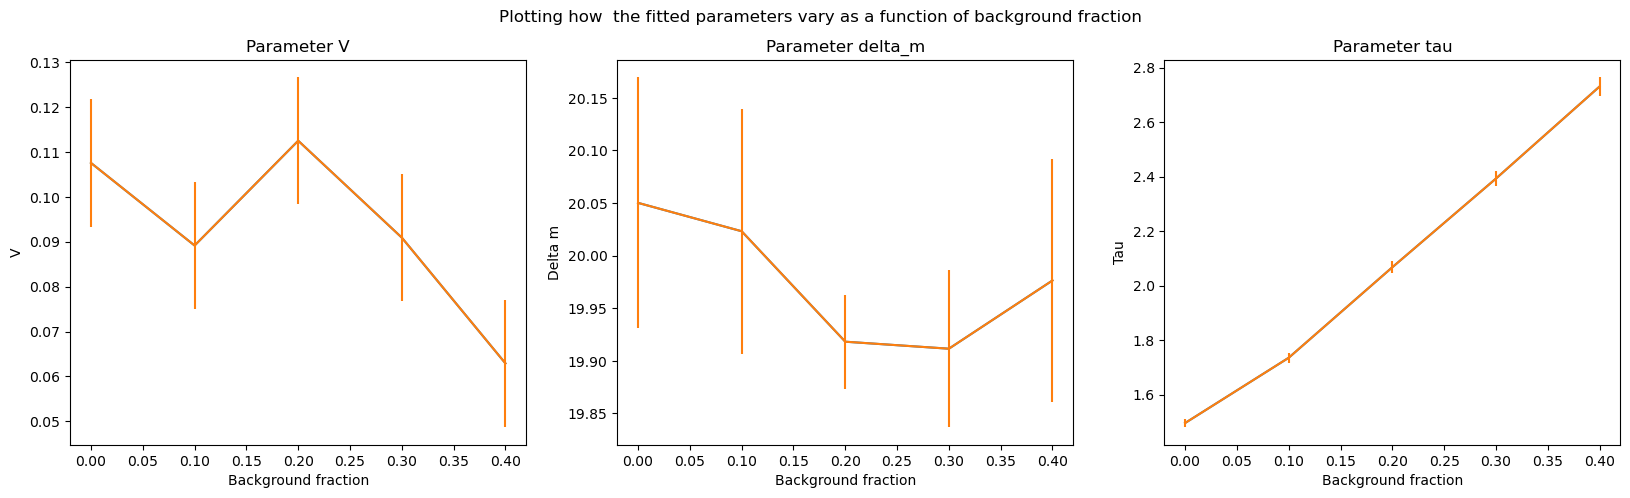

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

fig.suptitle('Plotting how  the fitted parameters vary as a function of background fraction')

ax1.set_title("Parameter V")
ax1.set(xlabel='Background fraction', ylabel='V')
ax1.plot(x, yv)
ax1.errorbar(x, yv, yerr=yverr)

ax2.set_title("Parameter delta_m")
ax2.set(xlabel='Background fraction', ylabel='Delta m')
ax2.plot(x,ym)
ax2.errorbar(x, ym, yerr=ymerr)

ax3.set_title("Parameter tau")
ax3.set(xlabel='Background fraction', ylabel='Tau')
ax3.plot(x,yt)
ax3.errorbar(x, yt, yerr=yterr)

plt.show()

The plot for parameter V shows a slight but general decrease. From the equation for the signal pdf: $( 1 + V sin(\Delta mt) )  e^{\frac{-t}{\tau}}$, V determines the amplitude of the oscillation within the signal. It therefore makes sense then for the value of V to decrease as the background fraction increases, as we would want to supress the amplitude of the oscillation within the signal to more closely match the simple background exponential decay. This can be seen visually in the "Combined pdf for different background fractions" plot.

The plot for paramter $\Delta m$ is suggesting the value stays roughly around the same (varying around some mean). From the equation for the signal pdf: $( 1 + V sin(\Delta mt) )  e^{\frac{-t}{\tau}}$, $\Delta m$ determines the frequency of oscillation within the signal. It therefore makes sense then for the value of $\Delta m$ to stay roughly the same, as fitting the 'signal only' pdf to the combined pdf will just flatten the amplitude of the oscillations to the exponential decay, irrespecrive of the frequency.

The plot for parameter $\tau$ shows a clear increase with background fraction. We know that $\tau$ is the exponential parameter, which determines how fast the pdf decays. Because the background has a much larger $\tau$, this means its exponential tails off for a lot longer. It therefore makes sense that as the background fraction increases, $\tau$ must also increase, as the 'signal only' pdf is trying to more closely fit a longer decay tail.



 Parameter | Background fraction| Mean value | Standard deviation | Bias   | 
:---------:|:------------------:|:----------:|:------------------:|:------:|
V          |        0           | 0.108      | 0.014              | -0.008  |                                           
$\Delta m$ |        0           | 20.05     | 0.12              | -0.05  |                                         
$\tau$     |        0           | 1.495      | 0.015              | 0.005  |  



 Parameter | Background fraction| Mean value | Standard deviation | Bias   | 
:---------:|:------------------:|:----------:|:------------------:|:------:|
V          |        0.1           | 0.089      | 0.014              | 0.011  |                                           
$\Delta m$ |        0.1           | 20.02     | 0.12              | -0.02  |                                         
$\tau$     |        0.1           | 1.735      | 0.018              | -0.235  |  



 Parameter | Background fraction| Mean value | Standard deviation | Bias   | 
:---------:|:------------------:|:----------:|:------------------:|:------:|
V          |        0.2           | 0.112      | 0.014              | -0.012  |                                           
$\Delta m$ |        0.2           | 19.92    | 0.04              | 0.08  |                                         
$\tau$     |        0.2           | 2.067      | 0.023              | -0.567  |  




 Parameter | Background fraction| Mean value | Standard deviation | Bias   | 
:---------:|:------------------:|:----------:|:------------------:|:------:|
V          |        0.3           | 0.091      | 0.014              | 0.009  |                                           
$\Delta m$ |        0.3           | 19.91     | 0.07              | 0.09  |                                         
$\tau$     |        0.3           | 2.392      | 0.028              | -0.892  |  




 Parameter | Background fraction| Mean value | Standard deviation | Bias   | 
:---------:|:------------------:|:----------:|:------------------:|:------:|
V          |        0.4           | 0.063      | 0.014              | 0.037  |                                           
$\Delta m$ |        0.4           | 19.98    | 0.12             | 0.02  |                                         
$\tau$     |        0.4           | 2.73      | 0.034             | -1.23  |  




Bias is defined as (original parameter value minus mean minimized paramater value).
Standard error is defined as the standard deviation divided by the square root of the number of number of data sets $\frac{\sigma}{\sqrt{N}}$
The precision of the bias is the standard error on the mean. However because only one 'toy' experiment was carried out for each signal fraction, the standard error is the same as the standard deviation. 

The only parameter which has a significant bias is $\tau$. As soon as the background distribution is introduced, the bias out-weighs the error on mean by an order of magnitude